In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# 0. Import Packages

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch

In [3]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# 1. Read Data

In [5]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [6]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [8]:
set(df_train.columns) - set(df_test.columns)

{'loan_status'}

In [9]:
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [10]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

# 2. Data EDA

In [11]:
df_train.shape,df_test.shape

((58645, 12), (39098, 11))

In [12]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [13]:
df_test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

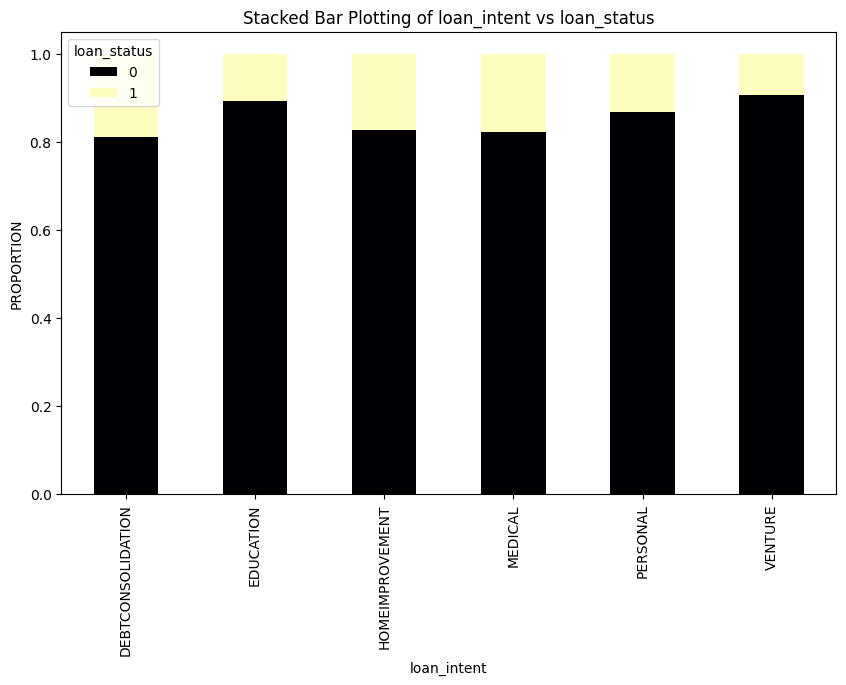

In [14]:
def stacked_bar_plot(df, feature, target='loan_status'):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='magma')
    plt.title(f'Stacked Bar Plotting of {feature} vs {target}')
    plt.ylabel('PROPORTION')
    plt.show()
stacked_bar_plot(df_train, 'loan_intent')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


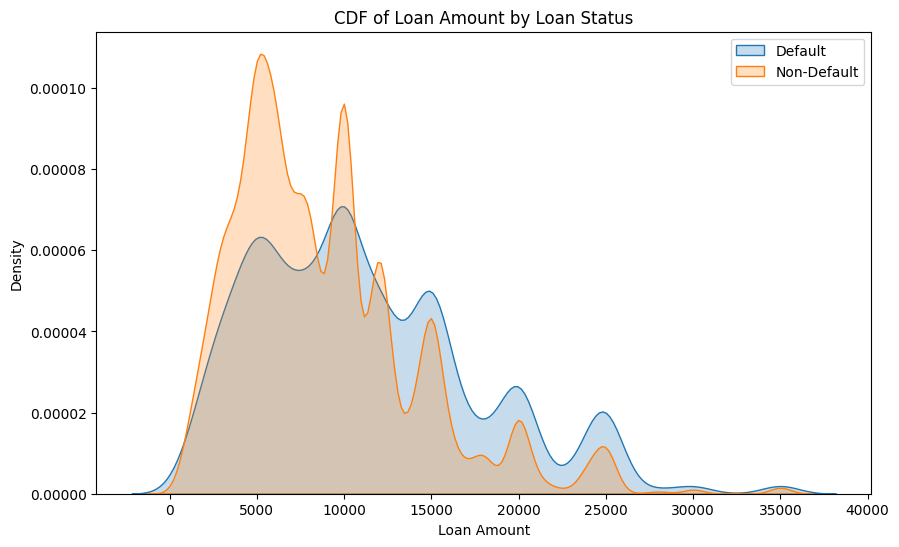

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train[df_train['loan_status'] == 1]['loan_amnt'], label='Default', fill=True)
sns.kdeplot(df_train[df_train['loan_status'] == 0]['loan_amnt'], label='Non-Default', fill=True)
plt.title('CDF of Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

In [16]:
target_df = pd.DataFrame()
target_df['loan_status'] = df_train['loan_status'] 
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

In [17]:
target_df['loan_status'].value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

In [18]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_train_data = X
# scaled_test_data = df_test

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


In [21]:
# df_train.drop(["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"], axis=1, inplace=True)
# df_test.drop(["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"], axis=1, inplace=True)

# 3. Data Processing

## 3.0 Data Types

In [22]:
int_cols = X.select_dtypes('int64').columns.to_list()
float_cols = X.select_dtypes('float64').columns.to_list()

obj_cols = X.select_dtypes('object').columns.to_list()

print(len(int_cols) + len(float_cols) + len(obj_cols))
print(X.shape)

11
(58645, 11)


In [23]:
temp = X.copy()

## 3.1 Feature Engineering

In [24]:
def transform(df):
    df['loan_to_income'] = ((df['loan_amnt'] / df['person_income']) - df['loan_percent_income'])
    df['age_income_interaction'] = (df['person_age'] * df['person_income'])
    df['loan_to_emp_length_ratio'] = (df['loan_amnt'] / (0.1 + df['person_emp_length']).astype('float'))
    df['monthly_debt'] = (df['loan_amnt'] * (1 + df['loan_int_rate']) / 12)
    
    monthly_income = df['person_income'] / 12
    df['dti_ratio'] = (df['monthly_debt'] / monthly_income)
    
    df['monthly_debt'] = (df['loan_amnt'] * (1 + df['loan_int_rate']) / 12)
    df['risk_flag'] = (np.where((df['cb_person_default_on_file'] == 'Y') & (df['loan_grade'].isin(['C', 'D', 'E'])), 1, 0))
    
    
    df['loan_int_rate'] = (df['loan_int_rate'] * 100)
    df['loan_percent_income'] = (df['loan_percent_income'] * 100)
    return df

In [25]:
temp = transform(temp)
print(temp.shape)
temp.head(3)

(58645, 17)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income,age_income_interaction,loan_to_emp_length_ratio,monthly_debt,dti_ratio,risk_flag
0,37,35000,RENT,0.0,EDUCATION,B,6000,1149.0,17.0,N,14,0.001429,1295000,60000.000000,6245.000000,2.141143,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,1335.0,7.0,N,2,0.001429,1232000,655.737705,4783.333333,1.025000,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,890.0,21.0,N,10,-0.001667,835200,740.740741,4950.000000,2.062500,0


In [26]:
int_cols = temp.select_dtypes('int64').columns.to_list()
float_cols = temp.select_dtypes('float64').columns.to_list()

obj_cols = temp.select_dtypes('object').columns.to_list()

print(len(int_cols) + len(float_cols) + len(obj_cols))
print(temp.shape)

17
(58645, 17)


## 3.2 Converting The Features Into Numericals

### 3.2.1 Numerical Columns

In [27]:
temp[int_cols].head(3)

,person_age,person_income,loan_amnt,cb_person_cred_hist_length,age_income_interaction,risk_flag
0,37,35000,6000,14,1295000,0
1,22,56000,4000,2,1232000,0
2,29,28800,6000,10,835200,0


In [28]:
temp[float_cols].head(3)

,person_emp_length,loan_int_rate,loan_percent_income,loan_to_income,loan_to_emp_length_ratio,monthly_debt,dti_ratio
0,0.0,1149.0,17.0,0.001429,60000.000000,6245.000000,2.141143
1,6.0,1335.0,7.0,0.001429,655.737705,4783.333333,1.025000
2,8.0,890.0,21.0,-0.001667,740.740741,4950.000000,2.062500


No extra transformation required

### 3.2.2 Categorical Columns

In [29]:
string_feat = temp[obj_cols].describe().T.reset_index().rename(columns = {'index': 'Feat'})
string_feat.head()

,Feat,count,unique,top,freq
0,person_home_ownership,58645,4,RENT,30594
1,loan_intent,58645,6,EDUCATION,12271
2,loan_grade,58645,7,A,20984
3,cb_person_default_on_file,58645,2,N,49943


In [30]:
for cat in obj_cols:
#     print(cat)
    print(temp[cat].value_counts(normalize=True))
    print("*"*20)

person_home_ownership
RENT        0.521681
MORTGAGE    0.423293
OWN         0.053508
OTHER       0.001518
Name: proportion, dtype: float64
********************
loan_intent
EDUCATION            0.209242
MEDICAL              0.186444
PERSONAL             0.170790
VENTURE              0.170705
DEBTCONSOLIDATION    0.155734
HOMEIMPROVEMENT      0.107085
Name: proportion, dtype: float64
********************
loan_grade
A    0.357814
B    0.347856
C    0.188183
D    0.085839
E    0.017205
F    0.002541
G    0.000563
Name: proportion, dtype: float64
********************
cb_person_default_on_file
N    0.851616
Y    0.148384
Name: proportion, dtype: float64
********************


In [31]:
cat_data = pd.get_dummies(
            temp[obj_cols],
            drop_first = True
)
cat_data = cat_data.astype(int)
print(cat_data.shape)
cat_data.head(3)

(58645, 15)


,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


## 3.4 Remove High Corr. Data

In [32]:
combined_df = pd.concat([temp[int_cols], temp[float_cols], cat_data, target_df['loan_status']], axis=1)
corr_matrix = combined_df.corr()

corr_with_target = corr_matrix['loan_status']
low_corr = corr_with_target[corr_with_target.abs() < 0.05]

filter_feat = corr_with_target[corr_with_target.abs() >= 0.05]
# filter_feat.drop('loan_status', axis = 0)

print('Low Corr. Feat. :\n')
print(low_corr)


print('1st Stage Feat. :\n')
print(len(filter_feat), '\n', filter_feat)

Low Corr. Feat. :

person_age                    -0.001130
cb_person_cred_hist_length    -0.003030
loan_to_income                 0.031176
person_home_ownership_OTHER    0.002918
loan_intent_HOMEIMPROVEMENT    0.031063
loan_intent_MEDICAL            0.049139
loan_intent_PERSONAL          -0.012461
loan_grade_C                  -0.009654
loan_grade_G                   0.045889
Name: loan_status, dtype: float64
1st Stage Feat. :

20 
 person_income                 -0.169956
loan_amnt                      0.144982
age_income_interaction        -0.150138
risk_flag                      0.180697
person_emp_length             -0.100428
loan_int_rate                  0.338948
loan_percent_income            0.378280
loan_to_emp_length_ratio       0.098961
monthly_debt                   0.247493
dti_ratio                      0.455077
person_home_ownership_OWN     -0.087556
person_home_ownership_RENT     0.239620
loan_intent_EDUCATION         -0.051005
loan_intent_VENTURE           -0.064378
loa

In [33]:
def filter_corr_columns(df, target='target', th = 0.7):
    corr_matrix = df.corr().abs()
    
    target_corr = corr_matrix[target].drop(labels = [target])
    columns_to_drop = set()
    
    for i in tqdm(range(len(corr_matrix.columns[:-1]))):
        for j in range(i+1, len(corr_matrix.columns[:-1])):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            
            if corr_matrix.loc[col1, col2] > th:
                print(f"Corr. : {corr_matrix.loc[col1, col2]}")
                if target_corr[col1] > target_corr[col2]:
                    columns_to_drop.add(col2)
                    
                    print(f"Drop Column: {col2} (Corr With {target}: {target_corr[col2]:.2f}),\
                    \Keep Column: {col1} (Corr with {target}: {target_corr[col1]:.2f})")
                else:
                    columns_to_drop.add(col1)
                    print(f"Drop Column: {col1} (Corr With {target}: {target_corr[col1]:.2f}),\
                    Keep Column: {col2} (Corr with {target}: {target_corr[col2]:.2f})")
                    
    df_filtered = df.drop(columns = columns_to_drop)
    return df_filtered
                
    

In [34]:
num_table = filter_corr_columns(combined_df, target='loan_status', th = 0.7)

100%|██████████| 28/28 [00:00<00:00, 2235.47it/s]

Corr. : 0.8742597354896693
Drop Column: person_age (Corr With loan_status: 0.00),                    Keep Column: cb_person_cred_hist_length (Corr with loan_status: 0.00)
Corr. : 0.9281219270339907
Drop Column: age_income_interaction (Corr With loan_status: 0.15),                    \Keep Column: person_income (Corr with loan_status: 0.17)
Corr. : 0.9118178264160725
Drop Column: loan_amnt (Corr With loan_status: 0.14),                    Keep Column: monthly_debt (Corr with loan_status: 0.25)
Corr. : 0.9926347196813035
Drop Column: risk_flag (Corr With loan_status: 0.18),                    Keep Column: cb_person_default_on_file_Y (Corr with loan_status: 0.19)
Corr. : 0.8722474107535992
Drop Column: loan_percent_income (Corr With loan_status: 0.38),                    Keep Column: dti_ratio (Corr with loan_status: 0.46)
Corr. : 0.7161217337082184
Drop Column: monthly_debt (Corr With loan_status: 0.25),                    Keep Column: dti_ratio (Corr with loan_status: 0.46)


In [35]:
num_table.drop('loan_status', axis = 1, inplace= True)
len(num_table.columns)


22

## 3.4 VIF

In [36]:
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed

def compute_vif_parallel(df):
    def compute_vif_single(column):
        x_columns = [i for i in df.columns if i != column]
        lr_model = LinearRegression().fit(df[x_columns], df[column])
        r2 = lr_model.score(df[x_columns], df[column])
        
        vif = 1/(1 - r2)
        return {"Variable":column, "VIF": vif}
    num_cores = -1
    vif_results = Parallel(n_jobs = num_cores)(
        delayed(compute_vif_single)(col) for col in df.columns
    )
    
    return vif_results

In [37]:
while True:
    temp = compute_vif_parallel(num_table)
    vif_data_sorted = pd.DataFrame(temp)
    vif_data_sorted.sort_values(by ='VIF', ascending= False, inplace=True)
    
    
    if vif_data_sorted.iloc[0, 1] > 6:
        print("Dropped: ", vif_data_sorted.iloc[0,0], "VIF", vif_data_sorted.iloc[0,1])
        drop_feat = vif_data_sorted.iloc[0,0]
        num_table.drop(drop_feat, axis = 1, inplace=True)
        print(num_table.shape[1])
    else:
        break

Dropped:  loan_int_rate VIF 11.047577512031427
21


## 3.5 Adjusting Test Set Accordingly

In [38]:
print(len(vif_data_sorted))

num_table.columns

21


Index(['person_income', 'cb_person_cred_hist_length', 'person_emp_length',
       'loan_to_income', 'loan_to_emp_length_ratio', 'dti_ratio',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_Y'],
      dtype='object')

In [39]:
df_test = transform(df_test)

In [40]:
test_num_data = pd.concat([df_test[int_cols], df_test[float_cols]], axis = 1 )
print(test_num_data.shape)
test_num_data.head(3)

(39098, 13)


,person_age,person_income,loan_amnt,cb_person_cred_hist_length,age_income_interaction,risk_flag,person_emp_length,loan_int_rate,loan_percent_income,loan_to_income,loan_to_emp_length_ratio,monthly_debt,dti_ratio
0,23,69000,25000,2,1587000,0,3.0,1576.0,36.0,0.002319,8064.516129,34916.666667,6.072464
1,26,96000,10000,4,2496000,1,6.0,1268.0,10.0,0.004167,1639.344262,11400.000000,1.425000
2,26,30000,4000,2,780000,1,5.0,1719.0,13.0,0.003333,784.313725,6063.333333,2.425333


In [41]:
test_cat_data = pd.get_dummies(
            df_test[obj_cols],
#             drop_first = True
)
test_cat_data = test_cat_data.astype(int)
print(test_cat_data.shape)
test_cat_data.head(3)

(39098, 19)


,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


In [42]:
test_combined_df = pd.concat([test_cat_data, test_num_data], axis=1)
print(test_combined_df.shape)
test_combined_df.head(3)

(39098, 32)


,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,...,cb_person_cred_hist_length,age_income_interaction,risk_flag,person_emp_length,loan_int_rate,loan_percent_income,loan_to_income,loan_to_emp_length_ratio,monthly_debt,dti_ratio
0,0,0,0,1,0,0,1,0,0,0,...,2,1587000,0,3.0,1576.0,36.0,0.002319,8064.516129,34916.666667,6.072464
1,1,0,0,0,0,0,0,0,1,0,...,4,2496000,1,6.0,1268.0,10.0,0.004167,1639.344262,11400.000000,1.425000
2,0,0,0,1,0,0,0,0,0,1,...,2,780000,1,5.0,1719.0,13.0,0.003333,784.313725,6063.333333,2.425333


In [43]:
final_test = test_combined_df[num_table.columns]
print(final_test.shape)
final_test.head(3)

(39098, 21)


,person_income,cb_person_cred_hist_length,person_emp_length,loan_to_income,loan_to_emp_length_ratio,dti_ratio,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,69000,2,3.0,0.002319,8064.516129,6.072464,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,96000,4,6.0,0.004167,1639.344262,1.425000,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,30000,2,5.0,0.003333,784.313725,2.425333,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1


# 4. Model Building

In [44]:
scaled_train_data = num_table
scaled_test_data = final_test
y = target_df['loan_status']

In [45]:
catboost_params = {
    'depth': 7,
    'learning_rate': 0.199,
    'bagging_temperature': 0.79,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'iterations': 400,
    'grow_policy': 'Lossguide',
    'eval_metric': 'AUC',
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

catboost_predictions = np.zeros(len(scaled_train_data))
catboost_true_labels = np.zeros(len(scaled_train_data))
catboost_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(skf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    catboost_model = CatBoostClassifier(**catboost_params)
    catboost_model.fit(X_train, y_train,
                       eval_set=(X_val, y_val),
                       early_stopping_rounds=10,
                       verbose=False)
  
    catboost_fold_preds = catboost_model.predict_proba(X_val)[:, 1]  
    catboost_fold_test_preds = catboost_model.predict_proba(scaled_test_data)[:, 1]  
    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val    
    catboost_test_predictions += catboost_fold_test_preds / n_splits
overall_metric_catboost = roc_auc_score(catboost_true_labels, catboost_predictions)
print("Overall AUC (CatBoostClassifier with StratifiedKFold):", overall_metric_catboost)

Overall AUC (CatBoostClassifier with StratifiedKFold): 0.951497913210263


# 5. Tune Thresholds

In [46]:
from sklearn.metrics import roc_curve, auc
fpr_cat, tpr_cat, thresholds = roc_curve(catboost_true_labels, catboost_predictions)
roc_auc_xgb = auc(fpr_cat, tpr_cat)


j_scores = tpr_cat - fpr_cat
j_index = np.argmax(j_scores)
best_threshold = thresholds[j_index]
print(best_threshold)

0.14323992313461248


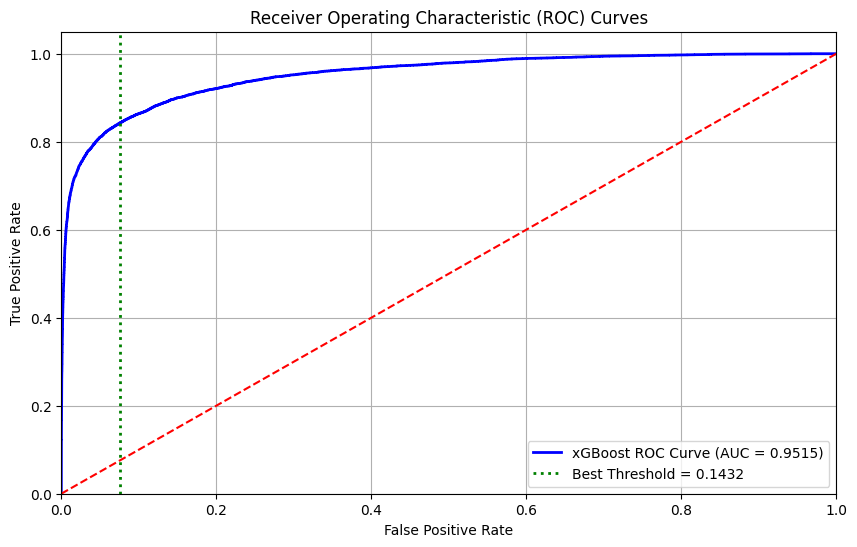

In [47]:

plt.figure(figsize=(10, 6))

plt.plot(fpr_cat, tpr_cat, color='blue', lw=2, label=f'xGBoost ROC Curve (AUC = {roc_auc_xgb:.4f})')
plt.axvline(x=fpr_cat[j_index], color='green', linestyle=':', lw=2, label=f'Best Threshold = {best_threshold:.4f}')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 99. Submission

In [48]:
df_sub['loan_status'] = [1 if x > best_threshold else 0 for x in catboost_test_predictions]
df_sub.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


In [49]:
df_sub.to_csv('submission.csv', index=False)